In [1]:
!pip install everywhereml --quiet

In [2]:
import librosa
import numpy as np
import pandas as pd
from os.path import join
from os import listdir
from scipy.io import wavfile
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomUniform
from everywhereml.code_generators.tensorflow import tf_porter

In [3]:
def create_dnn_mini(in_shape):
    model = Sequential()
    model.add(Dense(8,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(32,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="relu"))
    model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dense(2,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="softmax"))

    model.compile(optimizer="Adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [4]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

In [5]:
RECORDING_DIR = "/kaggle/input/rainfall-processed-16khz-16bit/processed_dataset/"
HEADER_FILES_FOLDER="/kaggle/working/"
HEADER_FILE_NAME = "dnn_model.h"
CLASSES = ["rain", "ambient"]
EPOCHS = 30
BATCH_SIZE = 16
SAMPLE_DURATION = 1
SAMPLING_RATE = 16000
VALIDATION_SPLIT = 0.25
VALIDATION_LOSS_CUTOFF = 0.02

In [6]:
file_names = []
target = []

for label in CLASSES:
    fnames = listdir(join(RECORDING_DIR, label))
    num_samples = len(fnames)
    file_names.extend(fnames)
    target.extend([label] * num_samples)

In [7]:
result_df = pd.DataFrame()
basic_data = pd.DataFrame()
basic_data["filename"] = file_names
basic_data["class"] = target
basic_data["target"] = basic_data["class"].replace({"ambient": 0, "rain": 1})

In [8]:
def create_dnn_data(basic_data):
    spectrum_data = np.empty((0, SAMPLING_RATE*SAMPLE_DURATION), float)
    for index, row in basic_data.iterrows():
        file_path = join(RECORDING_DIR, row["class"], row["filename"])
        Fs, x = wavfile.read(file_path)
        xfft = np.abs(np.fft.fft(x))
        xfft = xfft.astype(np.int16)
        spectrum_data = np.vstack([spectrum_data, xfft])
    return spectrum_data

In [9]:
spectrum_data = create_dnn_data(basic_data)
basic_data["target"] = pd.to_numeric(basic_data["target"])
X_train, X_test, y_train, y_test = train_test_split(spectrum_data,
                                                    basic_data["target"],
                                                    test_size=VALIDATION_SPLIT,
                                                    random_state=2)

In [10]:
model = create_dnn_mini(X_train[0].shape)
cp_callback = ModelCheckpoint(filepath="./model/dnn.hdf5",
                              monitor="val_loss",
                              verbose=0,
                              save_best_only=True,
                              mode="min")

In [11]:
history = model.fit(X_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(X_test, y_test),
                callbacks=[cp_callback],
                verbose=1)

Epoch 1/30
23/23 [==============================] - 2s 31ms/step - loss: 98.8673 - accuracy: 0.4861 - val_loss: 10.4883 - val_accuracy: 0.6000
Epoch 2/30
23/23 [==============================] - 0s 8ms/step - loss: 6.6756 - accuracy: 0.6889 - val_loss: 9.2936 - val_accuracy: 0.5667
Epoch 3/30
23/23 [==============================] - 0s 7ms/step - loss: 1.9904 - accuracy: 0.7889 - val_loss: 8.9396 - val_accuracy: 0.5500
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 1.3249 - accuracy: 0.7972 - val_loss: 7.8003 - val_accuracy: 0.6750
Epoch 5/30
23/23 [==============================] - 0s 7ms/step - loss: 1.1018 - accuracy: 0.8250 - val_loss: 7.0519 - val_accuracy: 0.6167
Epoch 6/30
23/23 [==============================] - 0s 7ms/step - loss: 0.5156 - accuracy: 0.8444 - val_loss: 7.1457 - val_accuracy: 0.6167
Epoch 7/30
23/23 [==============================] - 0s 6ms/step - loss: 0.4619 - accuracy: 0.8500 - val_loss: 7.3291 - val_accuracy: 0.6083
Epoch 8/30
23/23 

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
row_df = pd.DataFrame({"EPOCHS": EPOCHS,
                       "Test_Accuracy":"{:5.2f}% ".format(100 * test_accuracy),
                       "Test_Loss":test_loss}, index=[0])

result_df = pd.concat([result_df, row_df])

4/4 [==============================] - 0s 3ms/step - loss: 8.0615 - accuracy: 0.7250


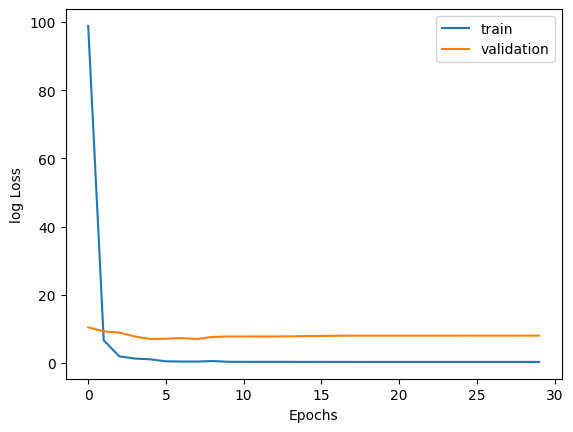

In [13]:
plot_history(history)

In [14]:
result_df

,EPOCHS,Test_Accuracy,Test_Loss
0,30,72.50%,8.061499


In [15]:
model.load_weights("./model/dnn.hdf5")

In [16]:
porter = tf_porter(model, X_train, y_train)
cpp_code = porter.to_cpp(instance_name='dnn_model', arena_size=4096)

with open(join(HEADER_FILES_FOLDER, HEADER_FILE_NAME), "w") as f:
        f.write(cpp_code)